# **Fundamentals**

In [1]:
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt

In [2]:
#Linear regression formula to make a straight line with known parameters
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

In [3]:
#Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

In [4]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  plt.figure(figsize=(10, 7))

  plt.scatter(train_data, train_labels, c="b", s=4, label="Training Data")
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing Data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  plt.legend(prop={"size": 14})

In [5]:
#First PyTorch model
class LinearRegressionModel(nn.Module): #Inherit from nn modules (base class for all neural networks)
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias #return linear regression formula

In [6]:
#Create a random seed
torch.manual_seed(42)
model_0 = LinearRegressionModel()

loss_fn = nn.L1Loss() #Mean absolute error loss function
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01) #stochastic gradient descent optimizer
#lr = learning rate

In [7]:
#Training loop steps:
#1. Loop through data
#2. Forward propagation
#3. Calculate loss
#4. Optimizer zero grad
#5. Back propagation
#6. Optimizer step (gradient descent)

#Epoch: one loop through the data (hyperparameter)
epochs = 200

#Track different values
epoch_count = []
loss_count = []
test_loss_values = []

#1. Train data
for epoch in range(epochs):
  #Default state of model
  model_0.train() #Train mode in PyTorch sets all parameters that requires gradients to require gradients

  #2. Forward propagation
  y_pred = model_0(X_train)

  #3. Calculate loss
  loss = loss_fn(y_pred, y_train)

  #4. Optimizer zero grad (zeroes the gradient again, they accumulate by default)
  optimizer.zero_grad()

  #5. Back propagation
  loss.backward()

  #6. Step the optimizer (perform gradient descent)
  optimizer.step()

  #Testing
  model_0.eval() #Turns off different settings in the model not needed for evaluation/testing
  with torch.inference_mode(): #turns off gradient tracking & a few other things
    #1. Do forward pass
    test_pred = model_0(X_test)

    #2. Calculate loss
    test_loss = loss_fn(test_pred, y_test)

  #Append epochs and loss results
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_count.append(loss)
    test_loss_values.append(test_loss)

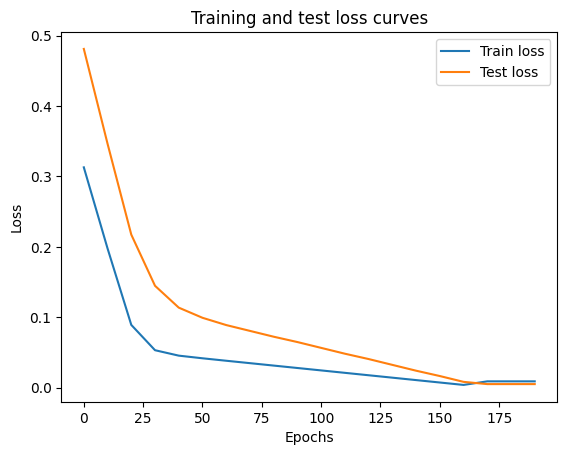

In [8]:
#Plot loss curves
np_loss_count = np.array(torch.tensor(loss_count).numpy())
np_test_loss_values = np.array(torch.tensor(test_loss_values).numpy())

#Matplotlib doesn't work with PyTorch so the tensors need to be converted to numpy arrays
plt.plot(epoch_count, np_loss_count, label="Train loss")
plt.plot(epoch_count, np_test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [9]:
#Saving a model in PyTorch

#torch.save() - saves a PyTorch object in Python's pickle formart
#torch.load() - loads a saved PyTorch object using Python's unpickling
#torch.nn.Module.load_state_dict() - loads a model's saved state dictionary

from pathlib import Path

#1. Create model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#2. Create a model save path
MODEL_NAME = "pytorch_workflow_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

#3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/pytorch_workflow_0.pth


In [10]:
#Loading a PyTorch model
loaded_model_0 = LinearRegressionModel()

#Load the saved state dict of model_0
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [11]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

OrderedDict([('linear_layer.weight', tensor([[0.6968]])),
             ('linear_layer.bias', tensor([0.3025]))])

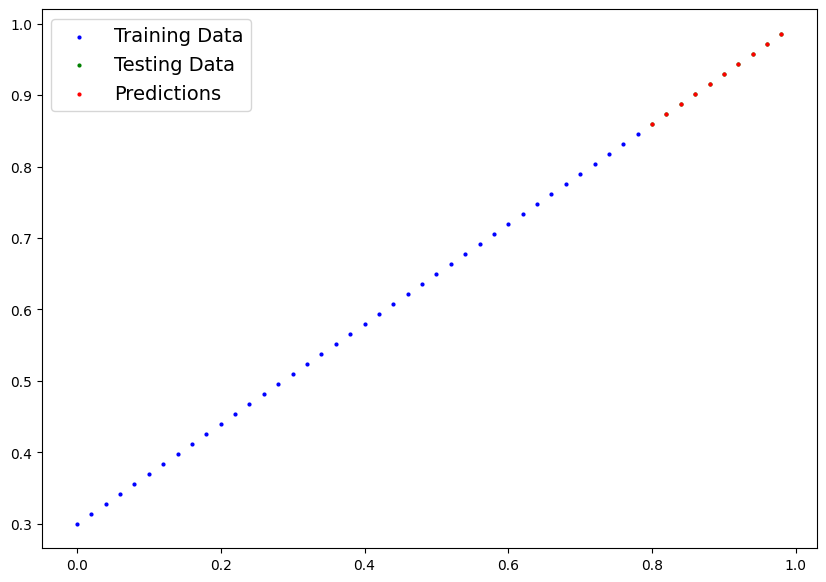

In [12]:
#Putting it all together

import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

#Create device-agnostic code. If we have access to a GPU we will use it. Otherwise default to CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

#Create data using linear regression formula
weight = 0.7
bias = 0.3

#Create range values
start = 0
end = 1
step = 0.02

#Create features and labels
X = torch.arange(start, end, step).unsqueeze(dim=1) #Without unsqueeze, errors will occur
y = weight * X + bias

#Split data
train_split = int(0.8 * len(X))
X_train, y_train, X_test, y_test = X[:train_split], y[:train_split], X[train_split:], y[train_split:]


#Create linear model by subclassing nn.Module
class LinearRegressionModelV2(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    #Use nn.Linear for creating model params
    self.linear_layer = nn.Linear(in_features=1, out_features=1) #(Take input of size 1 and output of size 1)

  #Overwrite the forwward method
  def forward(self, x:torch.Tensor):
    return self.linear_layer(x)


#Set manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()

#Set model and data to use target device
model_1.to(device)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

#Loss function and optimizer
loss_fn = nn.L1Loss() #mean absolute error
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

#Training data
epochs = 200
for epoch in range(epochs):
  model_1.train()

  #1. Forward pass
  y_pred = model_1(X_train)

  #2. Calculate loss
  loss = loss_fn(y_pred, y_train)

  #Zero the gradients
  optimizer.zero_grad()

  #.Backpropagation
  loss.backward()

  #Optimizer step
  optimizer.step()

  #Testing
  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)
    test_loss = loss_fn(test_pred, y_test)

#Plot our results
with torch.inference_mode():
  y_preds = model_1(X_test)
#Copying the tensor to host memory since matplotlib works with numpy, and numpy is CPU-based
plot_predictions(predictions=y_preds.cpu())

#Save model
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "pytorch_workflow_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)

#Load model
loaded_model_1 = LinearRegressionModelV2()
loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

#Set loaded model to target device
loaded_model_1.to(device)
loaded_model_1.state_dict()